In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [131]:
# === EDA for categorical variables ===
def categorical_counts_stats(df, N = 5):
    """
    print the counts of unique values for categorical and object values.
    """

    columns = df.select_dtypes(include=['object', 'category']).columns
    print(f'There are {len(columns)} categorical variables!')

    for col in columns:
        print("Categrorical variable: " + col)

        cate_counts = df[col].value_counts()
        cate_len = len(cate_counts)

        # reshape
        cate_counts = cate_counts.reset_index().rename(columns={"index": col, col: "Count"})

        print(cate_counts[:min(N, cate_len)])
    

def categorical_eda(df, columns=None, hue=None):
    """
    Plot count distribution of categorical data
    """

    # categorical_counts_stats(df)

    if columns is None:
        columns = df.select_dtypes(include='category').columns
    
    col = 2
    row = (len(columns) // col) + (0 if len(columns)%col==0 else 1)
    fig, ax = plt.subplots(row, col, figsize=(14, 4*row), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
    for i, column in enumerate(columns):
        ax_i = ax[i//col, i%col]
        g = sns.countplot(data=df, x=column, hue=hue, ax=ax_i)
        g.set_xticklabels(ax_i.get_xticklabels(), rotation=20)
        ax_i.yaxis.label.set_visible(False)

    plt.show()


# === Diagnosis ===
def check_duplicated(df, remove=False):
    duplicated_flag = df.duplicated()

    if sum(duplicated_flag) > 0:
        print(f"{sum(df.duplicated())} duplicated rows!")

        print('Remove duplicates...')

        df = df.drop_duplicates()

        check_duplicated(df)
        
        return df
    else:
        print('No duplicated rows!')

    # return duplicated_flag

def missing_heatmap(df):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # plot 1
    sns.heatmap(df.isna(), ax=ax[0])
    
    null_values_stats = df.isnull().sum(axis=0) # for each column
    if np.all(null_values_stats == 0):
        print('No missing values!')
    else:
        zero_null_values_stats = (null_values_stats / len(df)).sort_values(ascending=False)
        sns.set_color_codes("muted")
        sns.barplot(x=zero_null_values_stats.values, y=zero_null_values_stats.index, color='b', ax=ax[1])
    plt.show()
    
    return df.columns[df.isna().any(axis=0)]

def missing_table(df):
    null_values = df.isnull().sum(axis=0)

    if np.all(null_values == 0):
        return print('No missing values!')
        
    null_values = pd.DataFrame(null_values, columns=['counts'])
    null_values[null_values['counts']>0]
    null_values['percent'] = null_values['counts']/len(df)

    return round(null_values*100).sort_values('percent',ascending=False)


def cutIQR(cleaned_df, col, q1=0.25, q2=0.75):
    print('Remove outliers...')

    Q1 = cleaned_df[col].quantile(q1)
    Q3 = cleaned_df[col].quantile(q2)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    cutted_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]

    return cutted_df, upper


def clean_data(df_vehicles):
    # step1: missing values
    # for others, simply impute with unknown or generated from other features
    cleaned_df = df_vehicles.dropna(subset=['year'])

    # step2: remove extreme outlier
    cleaned_df,_ = cutIQR(cleaned_df, 'price', q2=0.85)
    
    cleaned_df = cleaned_df[cleaned_df['odometer'] <= 10000000]
    cleaned_df,_ = cutIQR(cleaned_df, 'odometer', q2=0.85)

    return cleaned_df


# 1. Load the data

In [2]:
!kaggle datasets download -d austinreese/craigslist-carstrucks-data -p data

!unzip data/craigslist-carstrucks-data.zip -d data


100%|███████████████████████████████████████▊| 266M/267M [00:16<00:00, 13.8MB/s]
100%|████████████████████████████████████████| 267M/267M [00:16<00:00, 17.4MB/s]
Archive:  data/craigslist-carstrucks-data.zip
  inflating: data/vehicles.csv       


# 2. Idenfity the variables

In [17]:

df_vehicles = pd.read_csv('./data/vehicles.csv')


In [18]:
df_vehicles = df_vehicles.drop(['Unnamed: 0'], axis=1)


In [119]:
df_vehicles.shape


(458213, 25)

In [20]:
df_vehicles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            458213 non-null  int64  
 1   url           458213 non-null  object 
 2   region        458213 non-null  object 
 3   region_url    458213 non-null  object 
 4   price         458213 non-null  int64  
 5   year          457163 non-null  float64
 6   manufacturer  439993 non-null  object 
 7   model         453367 non-null  object 
 8   condition     265273 non-null  object 
 9   cylinders     287073 non-null  object 
 10  fuel          454976 non-null  object 
 11  odometer      402910 non-null  float64
 12  title_status  455636 non-null  object 
 13  transmission  455771 non-null  object 
 14  VIN           270664 non-null  object 
 15  drive         324025 non-null  object 
 16  size          136865 non-null  object 
 17  type          345475 non-null  object 
 18  pain

In [21]:
df_vehicles[['id', 'odometer', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'region', 'paint_color', 'type', 'size', 'drive', 'transmission']].head(5)


,id,odometer,price,year,manufacturer,model,condition,cylinders,region,paint_color,type,size,drive,transmission
0,7240372487,32742.0,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,auburn,NaN,other,NaN,rwd,other
1,7240309422,93600.0,7500,2014.0,hyundai,sonata,excellent,4 cylinders,auburn,NaN,sedan,NaN,fwd,automatic
2,7240224296,87046.0,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,auburn,blue,SUV,NaN,NaN,automatic
3,7240103965,190000.0,2000,1974.0,chevrolet,c-10,good,4 cylinders,auburn,blue,pickup,full-size,rwd,automatic
4,7239983776,116000.0,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,auburn,blue,pickup,full-size,4wd,automatic


# 3. Examine data quality


## Duplicated rows

In [22]:

check_duplicated(df_vehicles)


No duplicated rows!


## Missing values

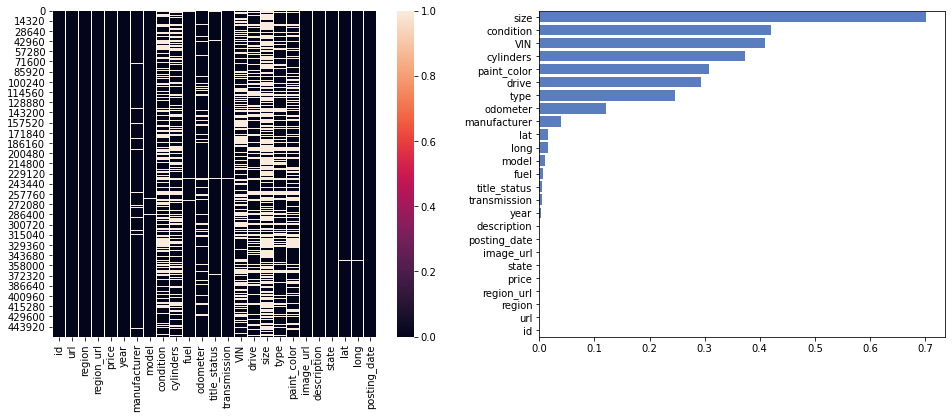

Index(['year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size',
       'type', 'paint_color', 'image_url', 'description', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [113]:
missing_heatmap(df_vehicles)


In [24]:
missing_table(df_vehicles)


,counts,percent
size,32134800,70.0
condition,19294000,42.0
VIN,18754900,41.0
cylinders,17114000,37.0
paint_color,14084300,31.0
drive,13418800,29.0
type,11273800,25.0
odometer,5530300,12.0
manufacturer,1822000,4.0
lat,744800,2.0


- condition, cylinders, odometer, VIN, drive, size, type, paint_color columns are almost filled with missing values.


- size and VIN need to be dropped.


## Outliers

In [115]:
df_vehicles.describe()


,id,price,year,odometer,lat,long
count,4.582130e+05,4.582130e+05,457163.000000,4.029100e+05,450765.000000,450765.000000
mean,7.235233e+09,4.042093e+04,2010.746067,1.016698e+05,38.531925,-94.375824
std,4.594362e+06,8.194599e+06,8.868136,3.228623e+06,5.857378,18.076225
min,7.208550e+09,0.000000e+00,1900.000000,0.000000e+00,-82.607549,-164.091797
25%,7.231953e+09,4.900000e+03,2008.000000,4.087700e+04,34.600000,-110.890427
50%,7.236409e+09,1.099500e+04,2013.000000,8.764100e+04,39.244500,-88.314889
75%,7.239321e+09,2.149500e+04,2016.000000,1.340000e+05,42.484503,-81.015022
max,7.241019e+09,3.615215e+09,2021.000000,2.043756e+09,82.049255,150.898969


- Price and odometer have outliers.


- the difference between 75% percentile and the max value is too large.


- Do we need remove zero value of odometer?



### Price

Remove outliers...


<AxesSubplot:>

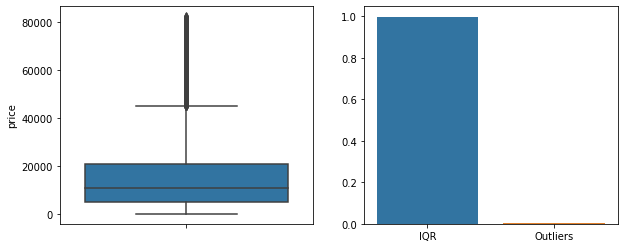

In [120]:
cutted_price, upper_price = cutIQR(df_vehicles, 'price', q1=0.1, q2=0.9)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot 1
sns.boxplot(data=cutted_price, y='price', ax=ax[0])

# plot 2
price_counts_df = pd.DataFrame({
    'IQR': [len(cutted_price) / len(df_vehicles)],
    'Outliers': [np.sum(df_vehicles['price'] > upper_price) / len(df_vehicles)]
})
sns.barplot(data=price_counts_df, ax=ax[1])


### Odometer

<AxesSubplot:xlabel='odometer', ylabel='price'>

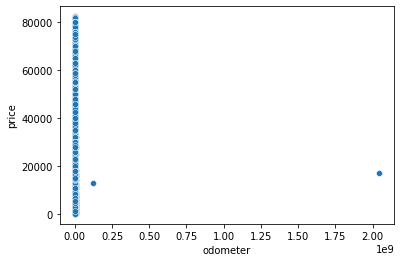

In [122]:
sns.scatterplot(data=cutted_price, x="odometer", y="price")


- There are several extreme outliers!! Let's remove it.

In [123]:
cutted_price['odometer'].max()


2043755555.0

In [124]:
cutted_odometer = cutted_price.drop(cutted_price[cutted_price['odometer'] == 2043755555.0 ].index)


In [125]:
cutted_odometer['odometer'].max()


123459789.0

In [126]:
cutted_odometer = cutted_odometer.drop(cutted_odometer[cutted_odometer['odometer'] == 123459789.0 ].index)


In [127]:
cutted_odometer['odometer'].max()


10000000.0

<AxesSubplot:xlabel='odometer', ylabel='price'>

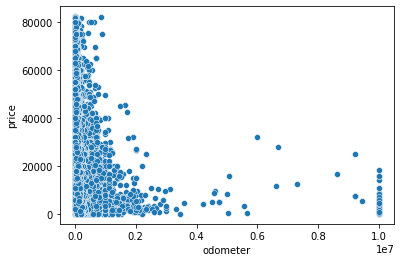

In [128]:
sns.scatterplot(data=cutted_odometer, x="odometer", y="price")


In [129]:
cutted_odometer['odometer'].describe()


count    4.020900e+05
mean     9.642234e+04
std      1.425106e+05
min      0.000000e+00
25%      4.101500e+04
50%      8.785100e+04
75%      1.341228e+05
max      1.000000e+07
Name: odometer, dtype: float64

Remove outliers...


<AxesSubplot:>

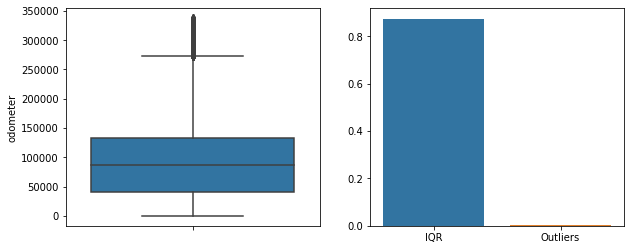

In [130]:
cutted_IQR_odometer, upper_odometer = cutIQR(cutted_odometer, 'odometer', q2=0.85)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot 1
sns.boxplot(data=cutted_IQR_odometer, y='odometer', ax=ax[0])


# plot 2
odometer_counts_df = pd.DataFrame({
    'IQR': [len(cutted_IQR_odometer) / len(df_vehicles)],
    'Outliers': [np.sum(df_vehicles['odometer'] > upper_odometer) / len(df_vehicles)]
})
sns.barplot(data=odometer_counts_df, ax=ax[1])


# 4. Univariate Analysis

## Categorical Distribution

In [15]:
cat_features = [
    'region', 'state', # region(405), state(51), 
    'manufacturer', 'condition', 'cylinders', 
    'fuel', 'title_status', 'transmission', 
    'drive', 'type', 'paint_color'  
]


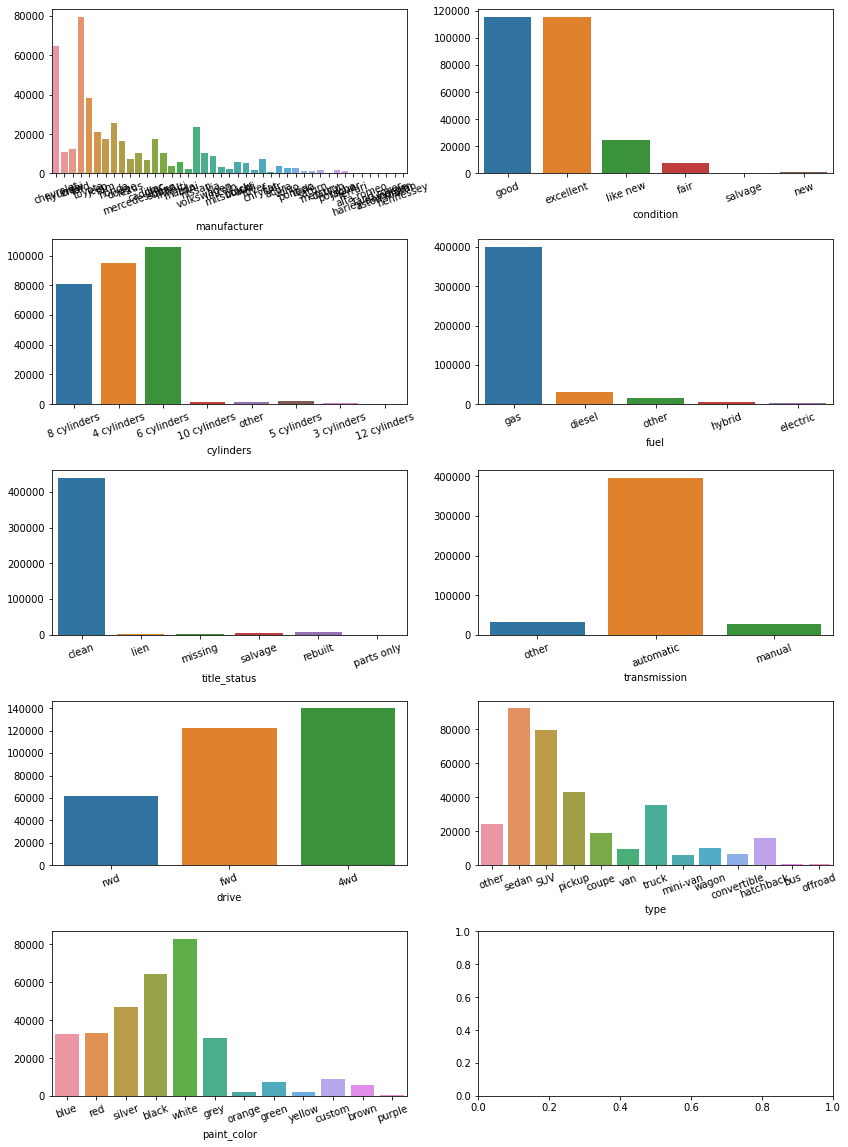

In [16]:

categorical_eda(df_vehicles, columns = cat_features[2:])


# 5. Bivariate Analysis

In [132]:

df = clean_data(df_vehicles)


Remove outliers...
Remove outliers...


## 1) Numerical vs Numerical

### Correlation

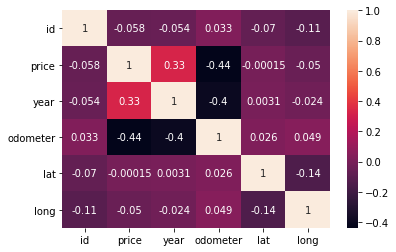

In [133]:
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True)

plt.show()


- year is positive correlated with price



- odometer is negative correlated with price


### By Year

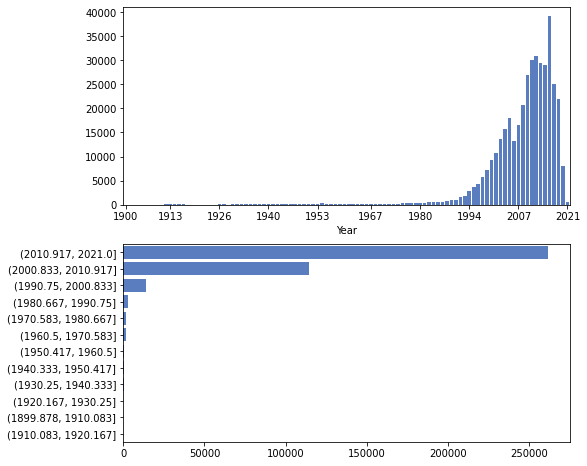

In [134]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
sns.set_color_codes("muted") 

year_counts = df['year'].value_counts()
g=sns.barplot(x=year_counts.index, y=year_counts.values, color='b', ax=ax[0])
ax[0].set_xlabel('Year')

xmin, xmax = ax[0].get_xlim()
ax[0].set_xticks(np.linspace(xmin, xmax, 10, dtype=int))
ax[0].set_xticklabels(np.linspace(1900, 2021, 10, dtype=int))


decades_counts = df['year'].value_counts(bins=12)
g=sns.barplot(x=decades_counts.values, y=decades_counts.index, color='b', ax=ax[1])


plt.show()


- Most used cars were made from 2010 to 2021.



<AxesSubplot:xlabel='year', ylabel='price'>

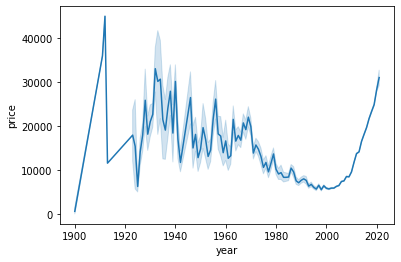

In [51]:
sns.lineplot(data=df, x='year', y = 'price')


- Antique cars (over 100 years) are the most expensive cars


- The price of cars made between 1920 and 1960 fluctuate significantly.


- After 1960, the price decreased constantly until 2000.


- The newer the cars are, the more expensive the price in the recent 20 years.



<AxesSubplot:xlabel='year', ylabel='price'>

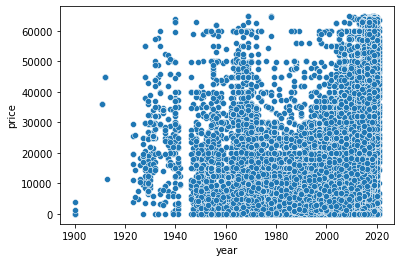

In [61]:
sns.scatterplot(data=df, x='year', y='price')


### By Odometer

<AxesSubplot:xlabel='odometer', ylabel='price'>

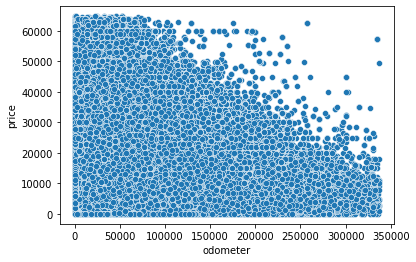

In [59]:
sns.scatterplot(data=df, x='odometer', y='price')


## 2) Categorical vs Numerical

<AxesSubplot:xlabel='company', ylabel='score'>

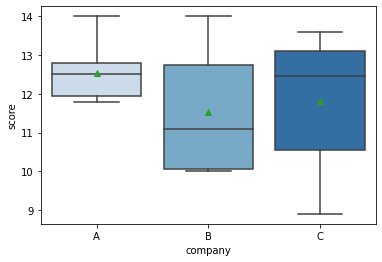

In [102]:

A = [12.6, 12, 11.8, 11.9, 13, 12.5, 14]
B = [10, 10.2, 10, 12, 14, 13]
C = [10.1, 13, 13.4, 12.9, 8.9, 10.7, 13.6, 12]

all_scores = A+B+C
company_names = ['A']*len(A)+ ['B']*len(B)+ ['C']*len(C)
data = pd.DataFrame({'company': company_names, 'score': all_scores})


sns.boxplot(data=data, y='score', x='company', showmeans=True, palette="Blues")


In [103]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm=ols('score~company', data=data).fit()
sm.stats.anova_lm(lm)


,df,sum_sq,mean_sq,F,PR(>F)
company,2.0,3.606905,1.803452,0.821297,0.455683
Residual,18.0,39.525476,2.195860,NaN,NaN


In [104]:
score_mean = data['score'].mean()
score_mse = sum((data['score']-score_mean)**2)

company_mean = data.groupby('company').mean()
company_mean=company_mean.rename(columns={'score': 'group_mean'})

data = data.merge(company_mean, left_on='company', right_index=True)
data['mean'] = [score_mean] * len(data)


In [113]:
ss_residual=sum((data['score']-data['group_mean'])**2)
ss_explained = sum((data['mean']-data['group_mean'])**2)

print('sum of squared residual', ss_residual)
print('sum of squared company', ss_explained)

n_group = len(data['company'].unique())
ms_residual = ss_residual / (len(data) - n_group)
ms_explained = ss_explained / (n_group - 1)
print('mean sq residual', ms_residual)
print('mean sq explained', ms_explained)

f_score = ms_explained/ms_residual
print('f_score', f_score)

import scipy.stats
p_value = 1 - scipy.stats.f.cdf(f_score, n_group-1, len(data)-n_group)
p_value


sum of squared residual 39.52547619047619
sum of squared company 3.6069047619047776
mean sq residual 2.1958597883597886
mean sq explained 1.8034523809523888
f_score 0.8212966923081592


0.4556832940515221